# Smoothing Required for a Good Coarsening $P$
We expect to need smoother TVs for $P$ than for $R$.

In [162]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [163]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 5

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.523385380551302


## Level 0->1 Coarsening

In [164]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level0 = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level0.location = np.arange(n)

### Coarsening

In [165]:
def create_coarsening(level, nu, aggregate_size, num_components):
    # Generate relaxed test vectors.
    x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
    _LOGGER.info("Generating relaxed TF with {} sweeps, RER {:.3f}".format(nu, norm(level.a.dot(x)) / norm(x)))
    #x_log.append(x)

    # Create coarsening. Force 2 coarse vars per aggregate so we can test alignment.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    R = r.tile(level.size // aggregate_size)
    return x, R

In [166]:
# Check Relaxation smoothing.
num_sweeps = hm.setup.auto_setup.check_relaxation_speed(0, level0)[1]
aggregate_size, num_components = 4, 2
x, R = create_coarsening(level0, 2 * num_sweeps, aggregate_size, num_components)

INFO     level 0 size 96 relax conv 0.93 shrinkage 0.64 PODR RER 0.55 after 5 sweeps. Work 1.0 eff 0.64
INFO     Generating relaxed TF with 10 sweeps, RER 0.312


### Interpolation Performance vs. #TF Sweeps

In [359]:
def two_level_performance(level, 
                          aggregate_size: int,
                          num_components: int,
                          max_cycle_sweeps: int,
                          num_tf_sweeps: int,
                          num_windows: int,
                          coarsening_types,
                          seed: int = 0,
                          weighted: bool = True):  # List[Tuple[caliber: int, r_restrict: int, symmetrize: int]] 
    np.random.seed(seed)
    num_cycle_sweeps = np.arange(1, max_cycle_sweeps + 1)
    # Create test functions.
    x = hm.analysis.ideal.ideal_tv(level.a, num_examples)[0] if nu == -1 \
                          else hm.setup.auto_setup.get_test_matrix(level.a, num_tf_sweeps, num_examples=num_examples)
    
    # Create R, measure mock cycle rates.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False, num_windows=num_windows)
    R = r.tile(level.size // aggregate_size)
    # TODO: replace by local mock cycle rate.
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in num_cycle_sweeps])

    l2c = []
    p_values = []
    for caliber, r_restrict, symmetrize in coarsening_types:
        # Create P, A^c, and a two-level hierarchy.
        p = hm.setup.auto_setup.create_interpolation(
            x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted, num_windows=num_windows)
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
            use_r_as_restriction=r_restrict, symmetrize=symmetrize)
        
        # Measure convergence and operator stats.
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in num_cycle_sweeps])
        l2c.append([False, caliber, r_restrict, symmetrize, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_values.append(p)
    return pd.DataFrame(np.array([[True, 0, False, False, 0, 0, False] + list(mock_conv)] + l2c),
        columns=("mock", "caliber", "r-restrict", "symmetrize", "nnz(P)", "Fill-in", "Symmetry") + tuple(num_cycle_sweeps)).astype(
        {"mock": bool, "caliber": int, "r-restrict": bool, "symmetrize": bool, "nnz(P)": int}), x, R, p_values

In [422]:
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 7)))
num_tf_sweeps = 16
num_windows = 32
coarsening_types = [
    (4, False, False),
    (4, True, False),
    (4, True, True)
]

# seed=5 strongly diverges.
for seed in range(13, 14):
    print("seed", seed)
    conv, x, R, p_values = two_level_performance(level0, aggregate_size, num_components, num_sweeps + 3,
                                                 num_tf_sweeps, num_windows, coarsening_types, 
                                                 weighted=weighted, seed=seed)
    display(conv)

seed 13


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.6010,0.3214,0.1838,0.1425,0.1417,0.1161,0.0908,0.0633
1,False,4,False,False,384,2.0000,0.0000,0.5999,0.3334,0.2058,0.1190,0.1374,0.1404,0.1009,0.0621
2,False,4,True,False,384,1.2000,0.0272,6.0023,0.5919,1.3434,0.5740,0.6748,0.2702,0.1818,0.1480
3,False,4,True,True,384,1.2000,0.0000,55.4614,9.1758,15.1867,6.4079,5.6353,1.7204,0.6493,1.1425


Looks like a $P^T A P$ gives good rated with with only $4$ TF sweeps. $8$ are required to get a good $R A P$. So we could possibly benefit from a bootstrap step, although the overhead might not even be justified here.

#### Applying Ritz Projection to TVs

In [428]:
print("lambda before ritz", np.array([level0.rq(x[:, i]) for i in range(x.shape[1])]))
x2, lam2 = hm.linalg.ritz(x, level0.operator)
#print(np.array([level0.rq(x2[:, i]) for i in range(x2.shape[1])]))
print("lambda after ritz ", lam2)

lambda before ritz [-0.046 -0.092 -0.012 -0.038 -0.093]
lambda after ritz  [ 0.01   0.051 -0.065 -0.122 -0.133]


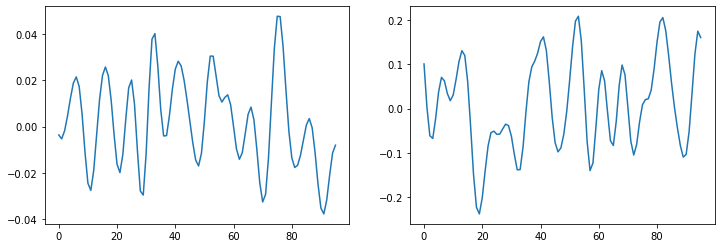

In [429]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(x[:, 0]);
axs[1].plot(x2[:, 0]);

### Create Level 1

INFO         0 |r| 1.730e+01 RER 3.36076
INFO         1 |r| 3.756e+01 (2.17148) RER 0.08543 (0.02542) 439.632
INFO         2 |r| 2.115e+02 (5.63159) RER 0.07424 (0.86898) 2849.116
INFO         3 |r| 1.209e+03 (5.71569) RER 0.07296 (0.98285) 16568.768
INFO         4 |r| 6.783e+03 (5.61091) RER 0.07254 (0.99424) 93504.736
INFO         5 |r| 3.721e+04 (5.48539) RER 0.07222 (0.99553) 515213.184
INFO         6 |r| 2.007e+05 (5.39448) RER 0.07204 (0.99754) 2786149.258
INFO         7 |r| 1.081e+06 (5.38665) RER 0.07213 (1.00116) 14990604.491
INFO         8 |r| 5.925e+06 (5.47965) RER 0.07246 (1.00467) 81761635.754
INFO         9 |r| 3.333e+07 (5.62577) RER 0.07284 (1.00526) 457565780.545
INFO        10 |r| 1.909e+08 (5.72807) RER 0.07302 (1.00238) 2614737209.993
INFO        11 |r| 1.093e+09 (5.72583) RER 0.07291 (0.99852) 14993680104.658
INFO        12 |r| 6.160e+09 (5.63454) RER 0.07261 (0.99595) 84826112215.848
INFO        13 |r| 3.393e+10 (5.50876) RER 0.07228 (0.99540) 469445315967.907
IN

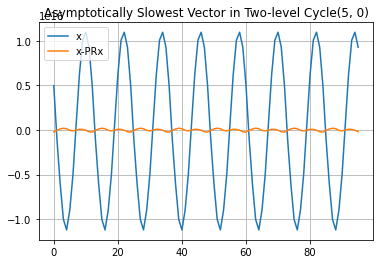

In [431]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P and RAP.

caliber = 4
num_windows = None
use_r_as_restriction = True #False
symmetrize = True # False
nu_tf = 64

p = p_values[0]
# x = hm.analysis.ideal.ideal_tv(level0.a, num_examples)[0] if nu_tf == -1 \
#     else hm.setup.auto_setup.get_test_matrix(level0.a, nu_tf, num_examples=num_examples)

# # Create R, measure mock cycle rates.
# r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False, num_windows=num_windows)
# R = r.tile(level0.size // aggregate_size)

# p = hm.setup.auto_setup.create_interpolation(
#     x, level0.a, R, level0.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
#     neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
#     caliber=caliber, fit_scheme=fit_scheme, weighted=weighted, num_windows=num_windows)

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level0.a, level0.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction,
    symmetrize=symmetrize)

nu = 5
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({}, 0)".format(nu))
# y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");

plt.grid(True);
plt.legend();

In [432]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [ 0.     0.     0.065  0.065 -0.074 -0.074  0.12   0.12  -0.155 -0.155  0.165  0.165]


In [409]:
# pd.DataFrame(m0[1]._p.todense())

## Level 1->2
Loading a 6-point stencil obtained by 4/2 coarsening of level 0 from file.

In [ ]:
a1 = scipy.sparse.load_npz('level_1_operator.npz')
level1 = hm.setup.hierarchy.create_finest_level(a1)
level0_location = np.arange(2 * a1.shape[0]) #level0.location
level1.location = hm.setup.geometry.coarse_locations(level0_location, aggregate_size, num_components)
pd.DataFrame(a1.todense()[4:6, np.unique(a1[4:6].nonzero()[1])])

### Coarsening

In [ ]:
# Check Relaxation smoothing.
num_sweeps = hm.setup.auto_setup.check_relaxation_speed(0, level1)[1]
aggregate_size, num_components = 4, 2
x, R = create_coarsening(level1, 30 * num_sweeps, aggregate_size, num_components)

In [ ]:
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Interpolation Performance vs. #TF Sweeps

In [ ]:
#num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 10)))
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 10), [-1]))
#num_tf_sweeps = [8]
p_experiment = two_level_performance(level1, 10, num_tf_sweeps, aggregate_size, num_components)

* Here we require $32$ sweeps to get a good $P^T A P$, and $64$ to get a good $R A P$. So bootstrap is definitely beneficial. 
* Note that there is "relaxing too much": past $100$ sweeps, the 2-level convergence degrades. Some degeneration in the TFs likely.
* Also, $R A P$ becomes less symmetric then. This happens with both weighted/unweighted LS fitting.
* Mock cycle rates stabilize after $4-8$ relaxations.

## Notes
* A lot of samples with small # TF sweeps still gives us a good R because we have a large sample size for SVD.
* Ideal vectors work: $P^T A P$ with high order $P$ is good. $R A P$ is OK. So relaxing to the limit is fine, provided the vectors are orthogonalized.

## TODO

* Try ideal vectors.
* Do relaxations to generate an initial $P$.
* Bootstrap is for identifying slow-to-converge components and improve $P$ for them.
* $8$ TF sweeps only - what is the initial cycle rate? Does it have good shrinkage? Even if asymptotic rate is bad.
* Compare first mock cycle rates vs. 2-level cycle rates.
* Check if divergence is because the last cycles ar bad but before were good.
* Add orthogonalization / Ritz projection - does the result improve with more relax sweeps then?
* Do we need to regularize?
* Try larger domain, at which # relax does the problem start? Is it domain size dependent?

In [ ]:
p = p_experiment[True][-1]

In [ ]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 2
use_r_as_restriction = False
p = p_experiment[use_r_as_restriction][-1]  # P^T*A*P P high order
use_r_as_restriction = use_r_as_restriction

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level1.a, level1.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
e = y - m1[1].interpolate(m1[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();